## Plane Delays & Calculations

After the data cleaning process done in [DataPreparation.ipynb](./DataPreparation.ipynb), let's go ahead with the analysis!

In [2]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30,30)
%matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.graphics.gofplots import qqplot

from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.regressor import ResidualsPlot

## Importing `.csv`

In [4]:
df = pd.read_csv('wisconsin.csv')
df.head(2)
df.drop(df.columns[0], axis=1, inplace=True)

In [5]:
# all years are 2015
del df['YEAR']

In [6]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,airline_full_name,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,7,1,3,OO,3423,N170SY,MKE,SEA,1605,1603.0,-2.0,11.0,1614.0,260.0,254.0,231.0,1694,1805.0,12.0,1825,1817.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
1,7,2,4,OO,3423,N171SY,MKE,SEA,1605,1600.0,-5.0,14.0,1614.0,260.0,258.0,234.0,1694,1808.0,10.0,1825,1818.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
2,7,3,5,OO,3423,N170SY,MKE,SEA,1605,1605.0,0.0,17.0,1622.0,260.0,284.0,257.0,1694,1839.0,10.0,1825,1849.0,24.0,0,0,NaN,24.0,0.0,0.0,0.0,0.0,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
3,7,4,6,OO,3423,N173SY,MKE,SEA,1605,1558.0,-7.0,12.0,1610.0,260.0,247.0,224.0,1694,1754.0,11.0,1825,1805.0,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
4,7,5,7,OO,3423,N171SY,MKE,SEA,1605,1600.0,-5.0,11.0,1611.0,260.0,238.0,221.0,1694,1752.0,6.0,1825,1758.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931


In [7]:
departure_delay = df['DEPARTURE_DELAY']

In [8]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE'],
      dtype='object')

In [94]:
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].replace('nan', np.nan).fillna(0)
df['AIR_SYSTEM_DELAY'] = df['AIR_SYSTEM_DELAY'].replace('nan', np.nan).fillna(0)
df['SECURITY_DELAY'] = df['SECURITY_DELAY'].replace('nan', np.nan).fillna(0)
df['AIRLINE_DELAY'] = df['AIRLINE_DELAY'].replace('nan', np.nan).fillna(0)
df['LATE_AIRCRAFT_DELAY'] = df['LATE_AIRCRAFT_DELAY'].replace('nan', np.nan).fillna(0)
df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].replace('nan', np.nan).fillna(0)
df['TAXI_OUT'] = df['TAXI_OUT'].replace('nan', np.nan).fillna(0)
df['WHEELS_OFF'] = df['WHEELS_OFF'].replace('nan', np.nan).fillna(0)
df['ELAPSED_TIME'] = df['ELAPSED_TIME'].replace('nan', np.nan).fillna(0)
df['AIR_TIME'] = df['AIR_TIME'].replace('nan', np.nan).fillna(0)
df['WHEELS_ON'] = df['WHEELS_ON'].replace('nan', np.nan).fillna(0)
df['TAXI_IN'] = df['TAXI_IN'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].replace('nan', np.nan).fillna(0)

In [16]:
cancelled_2 = df[df['CANCELLED'] != 0]

In [17]:
cancelled_2

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,airline_full_name,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
149,12,28,1,OO,3423,N173SY,MKE,SEA,1645,NaN,NaN,NaN,NaN,270.0,NaN,NaN,1694,NaN,NaN,1915,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
641,8,21,5,AA,639,NaN,MKE,PHX,1710,NaN,NaN,NaN,NaN,220.0,NaN,NaN,1460,NaN,NaN,1850,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Phoenix,AZ,33.43417,-112.00806
790,12,13,7,AA,435,NaN,MKE,PHX,659,NaN,NaN,NaN,NaN,251.0,NaN,NaN,1460,NaN,NaN,1010,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Phoenix,AZ,33.43417,-112.00806
819,12,28,1,AA,533,NaN,MKE,PHX,1705,NaN,NaN,NaN,NaN,235.0,NaN,NaN,1460,NaN,NaN,2000,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Phoenix,AZ,33.43417,-112.00806
881,2,1,7,US,615,NaN,MKE,PHX,1715,NaN,NaN,NaN,NaN,233.0,NaN,NaN,1460,NaN,NaN,2008,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,Milwaukee,WI,42.94722,-87.89658,Phoenix,AZ,33.43417,-112.00806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51202,5,17,7,OO,7415,N418SW,RHI,IMT,2130,NaN,NaN,NaN,NaN,43.0,NaN,NaN,67,NaN,NaN,2213,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Rhinelander,WI,45.63119,-89.46745,Iron Mountain/Kingsford,MI,45.81835,-88.11454
51323,11,4,3,OO,7415,N427SW,RHI,IMT,2128,NaN,NaN,NaN,NaN,43.0,NaN,NaN,67,NaN,NaN,2211,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Rhinelander,WI,45.63119,-89.46745,Iron Mountain/Kingsford,MI,45.81835,-88.11454
51334,11,17,2,OO,7415,N448SW,RHI,IMT,2128,NaN,NaN,NaN,NaN,43.0,NaN,NaN,67,NaN,NaN,2211,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Rhinelander,WI,45.63119,-89.46745,Iron Mountain/Kingsford,MI,45.81835,-88.11454
51349,12,6,7,OO,7415,N910EV,RHI,IMT,2144,NaN,NaN,NaN,NaN,48.0,NaN,NaN,67,NaN,NaN,2232,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Rhinelander,WI,45.63119,-89.46745,Iron Mountain/Kingsford,MI,45.81835,-88.11454


In [19]:
delayed = df[df['DEPARTURE_DELAY'] > 0]
delayed

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,airline_full_name,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
15,7,16,4,OO,3423,N173SY,MKE,SEA,1605,1613.0,8.0,11.0,1624.0,260.0,259.0,242.0,1694,1826.0,6.0,1825,1832.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
17,7,18,6,OO,3423,N173SY,MKE,SEA,1605,1627.0,22.0,11.0,1638.0,260.0,250.0,231.0,1694,1829.0,8.0,1825,1837.0,12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
21,7,22,3,OO,3423,N173SY,MKE,SEA,1605,1611.0,6.0,14.0,1625.0,260.0,255.0,232.0,1694,1817.0,9.0,1825,1826.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
33,8,3,1,OO,3423,N173SY,MKE,SEA,1605,1612.0,7.0,14.0,1626.0,260.0,251.0,230.0,1694,1816.0,7.0,1825,1823.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
38,8,8,6,OO,3423,N171SY,MKE,SEA,1605,1613.0,8.0,17.0,1630.0,260.0,255.0,231.0,1694,1821.0,7.0,1825,1828.0,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51358,12,16,3,OO,7415,N935SW,RHI,IMT,2144,2211.0,27.0,32.0,2243.0,48.0,56.0,13.0,67,2256.0,11.0,2232,2307.0,35.0,0,0,NaN,8.0,0.0,0.0,27.0,0.0,Skywest Airlines Inc.,Rhinelander,WI,45.63119,-89.46745,Iron Mountain/Kingsford,MI,45.81835,-88.11454
51364,12,23,3,OO,7415,N885AS,RHI,IMT,2144,2215.0,31.0,8.0,2223.0,48.0,30.0,17.0,67,2240.0,5.0,2232,2245.0,13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Rhinelander,WI,45.63119,-89.46745,Iron Mountain/Kingsford,MI,45.81835,-88.11454
51370,12,29,2,OO,7415,N477CA,RHI,IMT,2144,2256.0,72.0,24.0,2320.0,48.0,45.0,17.0,67,2337.0,4.0,2232,2341.0,69.0,0,0,NaN,0.0,0.0,0.0,69.0,0.0,Skywest Airlines Inc.,Rhinelander,WI,45.63119,-89.46745,Iron Mountain/Kingsford,MI,45.81835,-88.11454
51371,12,30,3,OO,7415,N452SW,RHI,IMT,2144,2151.0,7.0,29.0,2220.0,48.0,48.0,16.0,67,2236.0,3.0,2232,2239.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Rhinelander,WI,45.63119,-89.46745,Iron Mountain/Kingsford,MI,45.81835,-88.11454


# Dataset exploration

## Visual exploration

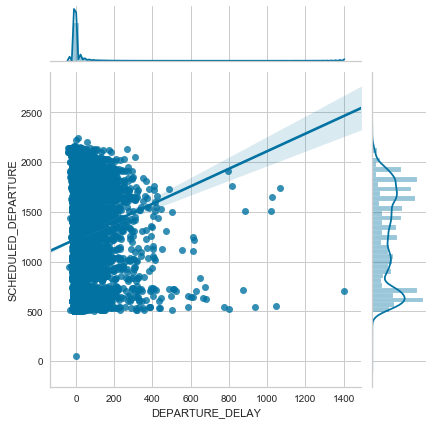

In [23]:
sns.jointplot('DEPARTURE_DELAY', 'SCHEDULED_DEPARTURE', data=df, kind='reg');

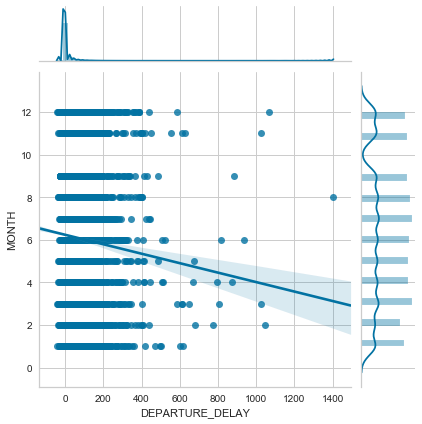

In [25]:
sns.jointplot('DEPARTURE_DELAY','MONTH', data=df, kind='reg');

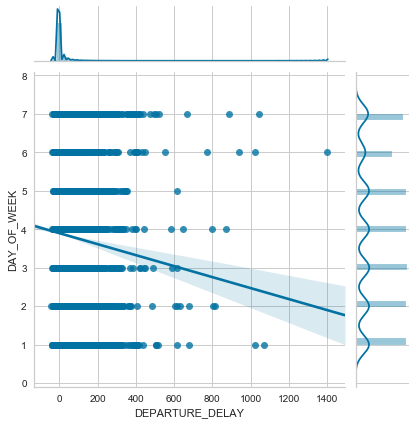

In [26]:
sns.jointplot('DEPARTURE_DELAY','DAY_OF_WEEK', data=df, kind='reg');

# Feature selection

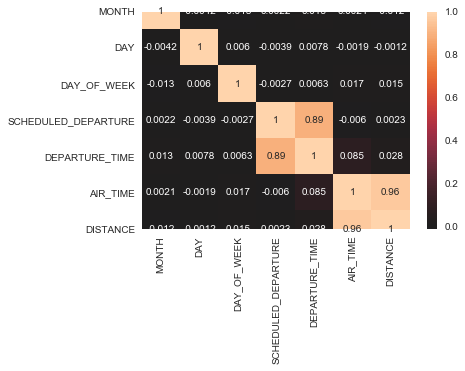

In [98]:
# 'AIRLINE',                  
# 'TAIL_NUMBER',              
# 'ORIGIN_AIRPORT',           
# 'CANCELLATION_REASON', 
# 'DESTINATION_AIRPORT',

features = ['MONTH',                    
            'DAY',                      
            'DAY_OF_WEEK',                 
            'SCHEDULED_DEPARTURE',      
            'DEPARTURE_TIME',           
            'AIR_TIME',
            'DISTANCE',
           ]
#            
            #'DEPARTURE_DELAY',          
            #'TAXI_OUT',                 
            #'WHEELS_OFF'

            #'SCHEDULED_TIME',           
 #           'ELAPSED_TIME',             
  #          'AIR_TIME',                      
    #        'WHEELS_ON',                
     #       'TAXI_IN',                  
      #      'SCHEDULED_ARRIVAL',        
       #     'ARRIVAL_TIME',             
        #    'ARRIVAL_DELAY',            
         #   'DIVERTED',                 
          #  'CANCELLED',                
           # 'AIR_SYSTEM_DELAY',    
            #'SECURITY_DELAY',      
#            'AIRLINE_DELAY',            
 #           'LATE_AIRCRAFT_DELAY',      
  #          'WEATHER_DELAY',            
   #         'ORIGIN_CITY',              
    #        'ORIGIN_LATITUDE',          
     #       'ORIGIN_LONGITUDE',         
       #     'DESTINATION_CITY',         
        #    'DESTINATION_STATE',        
         #   'DESTINATION_LATITUDE',     
           # 'DESTINATION_LONGITUDE'    
      #     ]

target = df['DEPARTURE_DELAY']
dfFeatures = df[features]
sns.heatmap(dfFeatures.corr(), center=0, annot=True);

In [99]:
dfFeatures.corr()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,AIR_TIME,DISTANCE
MONTH,1.000000,-0.004171,-0.013049,0.002189,0.013170,0.002109,-0.012254
DAY,-0.004171,1.000000,0.006031,-0.003854,0.007792,-0.001930,-0.001231
DAY_OF_WEEK,-0.013049,0.006031,1.000000,-0.002749,0.006304,0.017001,0.015009
SCHEDULED_DEPARTURE,0.002189,-0.003854,-0.002749,1.000000,0.892183,-0.006024,0.002261
DEPARTURE_TIME,0.013170,0.007792,0.006304,0.892183,1.000000,0.085049,0.028272
AIR_TIME,0.002109,-0.001930,0.017001,-0.006024,0.085049,1.000000,0.962943
DISTANCE,-0.012254,-0.001231,0.015009,0.002261,0.028272,0.962943,1.000000


Using the VIF, we can assess the list of features we want to include in our model. We are still left with multicollinearity issues but the most obvious ones have been removed.

In [100]:
vif = [variance_inflation_factor(dfFeatures.values, i) for i in range(dfFeatures.shape[1])]
list(zip(dfFeatures.columns, vif))

[('MONTH', 3.7199830453057166),
 ('DAY', 3.545957596255872),
 ('DAY_OF_WEEK', 3.949150058490306),
 ('SCHEDULED_DEPARTURE', 45.56898413964895),
 ('DEPARTURE_TIME', 45.15820267678477),
 ('AIR_TIME', 54.80906856534015),
 ('DISTANCE', 44.70737025194641)]

# Baseline model

In [101]:
# Train/Test split (25%)
X_train, X_test, y_train, y_test = train_test_split(dfFeatures,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=100
                                                   )
# Initialising K-Folds
kfold = KFold(n_splits=5, random_state=100, shuffle=True)

In [102]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

38532 12844 38532 12844


## Linear regression model generation

In [103]:
# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# model type
linmodel = LinearRegression()

# modelling itself
linmodel.fit(X_train_s,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Evaluating the baseline model

In [104]:
crossval = cross_validate(linmodel,
                          X_train_s,
                          y_train,
                          scoring=('r2', 'neg_mean_squared_error'),
                          cv=kfold,
                          return_train_score=True
                         )
for key, value in crossval.items():
    print(key, np.mean(value))

fit_time 0.04077649116516113
score_time 0.007396602630615234
test_r2 0.09640135919187565
train_r2 0.09464820858408844
test_neg_mean_squared_error -1397.5330021582486
train_neg_mean_squared_error -1396.345728838378


As we can see above, our Rsquared value is just above 0.5 for our train dataset and just below 0.5 for our test dataset. This means the model fits the training dataset slighlty better than the test one. However, as we are using a Kfold method, the test dataset is a portion of the training dataset and each portion - or fold - is used sequentially as the test dataset. The 0.49 value is an average of those iterations.

In [105]:
# The coefficients (standardised)
for i, column in enumerate(X_train.columns):
    print(f"The coefficient for {column} is {round(linmodel.coef_[i],5)}")
print('----------------------')
# The intercept
print(f'The intercept is {linmodel.intercept_}')

The coefficient for MONTH is -0.97855
The coefficient for DAY is -0.93068
The coefficient for DAY_OF_WEEK is -1.25363
The coefficient for SCHEDULED_DEPARTURE is -24.90916
The coefficient for DEPARTURE_TIME is 30.83392
The coefficient for AIR_TIME is -26.80036
The coefficient for DISTANCE is 25.63911
----------------------
The intercept is 6.497404754489779


In [106]:
# MSE and R_squared
# y_hat_train = linmodel.predict(X_train_s)
# train_mse = mean_squared_error(y_train, y_hat_train)
# print(f'Train Mean Squarred Error: {train_mse}')
# print(f'Train Rsquared:{r2_score(y_train, y_hat_train)}')

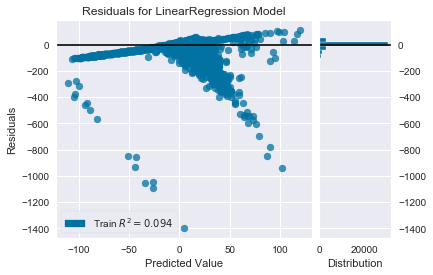

In [107]:
visualizer = ResidualsPlot(linmodel)
visualizer.fit(X_train_s, y_train)
# visualizer.score(X_test_train_s, y_test)
visualizer.show();






This graph tells us we have excelled ourselves lol

# Overfitting the model

In this section, we are going to polynomise our train dataset in order to maximise the Rsquared value (the goodness of fit indicator). We've tried all integers up to 5 (Rsquared = 1) but a cubic transformation brings a 0.64 Rsquare value which is more than enough considering the feature expansion trade-off. (considering our 10 variables, a third degree polynomial means we have about 286 features and interactions to analyse, a fourth degree brings us to 1001!)

In [108]:
# Polynomial transformation
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)

# Standardisation
X_poly_s = scaler.fit_transform(X_poly)

# Modellisation
model = LinearRegression()
lin_reg_1 = model.fit(X_poly_s,y_train)

# Evaluation
y_pred = lin_reg_1.predict(X_poly_s)
print(f'Rsquared: {r2_score(y_train,lin_reg_1.predict(X_poly_s))}')

Rsquared: 0.791966005340359


In [109]:
X_poly_s.shape

(38532, 120)

# Reducing the fit: LASSO, Ridge and Elastic net regressions

### Hyperparameter tuning

We are going to use GridSearchCV in order to automatise the search of the best alpha value to use. the `np.linspace()` parameters were manually changed depending on the results returned. We would narrow the parameters down closer to the result returned so on the next pass, alpha would be more accurate.

Cells have been commented out because they take a reasonable amount of time to compute.

In [110]:
# ridge = Ridge()
# # alpha was narrowed down manually
# ridge_params = {'alpha' : np.linspace(503,505)}

# grid = GridSearchCV(estimator = ridge, 
#                     param_grid = ridge_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1,
#                     return_train_score=True
#                    )

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 503.81633
## Rsquared: 0.52342

# pd.DataFrame(grid.cv_results_) give the detail of the cross validation results for all the alpha values

In [111]:
# lasso = Lasso()
# # alpha was narrowed down manually
# lasso_params = {'alpha' : np.linspace(.004, .005)}

# grid = GridSearchCV(estimator = lasso, 
#                     param_grid = lasso_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.00469
## Rsquared: 0.52799

In [112]:
# enet = ElasticNet()
# # alpha was narrowed down manually
# elastic_params = {'alpha' : np.linspace(0, .5)}

# grid = GridSearchCV(estimator = enet, 
#                     param_grid = elastic_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.0102
## Rsquared: 0.52825

## Model selection

Based on Rsquared values, the ElasticNet (0.52825) performes better than the Lasso (0.52799) which performs better than the Ridge model (0.52342). However, considering our polynomial is cubic, we are going to select the Lasso model as it removes most of the features generated during the polynomisation step. This will hopefully allow the model to be more interpretable.

Here is a summary of the coefficients, for informational purposes only.

In [113]:
ridge = Ridge(alpha=503.81633)
ridge.fit(X_poly_s, y_train)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)

enet = ElasticNet(alpha=0.0102)
enet.fit(X_poly_s, y_train)

# The following coefficients are transformed and scaled
# (as they work on the _poly_ data)
print('LinearRegression parameter coefficients:', linmodel.coef_)
print('----------------------')
print('Ridge parameter coefficients:', ridge.coef_)
print('----------------------')
print('Lasso parameter coefficients:', lasso.coef_)
print('----------------------')
print('Elastic net parameter coefficients:', enet.coef_)

LinearRegression parameter coefficients: [ -0.97855085  -0.93067702  -1.25363371 -24.90916283  30.83392332
 -26.8003583   25.63911437]
----------------------
Ridge parameter coefficients: [ 0.00000000e+00 -2.60046010e+00 -8.29102800e-01 -1.31982163e+00
 -2.39912774e+00  5.57529429e+00 -4.54983259e+00  2.18423453e+00
  2.96552499e-01  7.02864805e-01 -1.17565884e+00 -7.21055668e-01
 -6.38054436e-01 -1.43992127e+00  1.88677673e+00 -5.35262072e-01
 -7.66322079e-02 -3.13131819e+00  2.98331644e+00 -3.63088920e+00
  1.10292973e+00  6.37114592e-01 -1.82198105e+00  6.49009822e-01
 -1.96656394e+00  1.84289299e+00 -1.44647750e+00 -3.62975060e+01
 -1.34606387e+01  9.62452831e-01  4.11350009e+01  1.26195697e+01
  2.04205409e+00  2.22098466e+00  6.75609938e-01  4.46261043e-01
  1.36357275e+00  2.11161329e+00  1.51938824e-01  2.70464560e-01
  3.99582879e-01 -1.46305503e+00 -8.74385011e-01  4.89889110e-01
  2.58978116e-01 -9.35142158e-01  1.08484075e+00 -1.15623990e+00
  2.32123866e-02 -4.01390535e-01

# Testing the model

Training score: 0.7391526622577185
Testing score: 0.8740003167920805


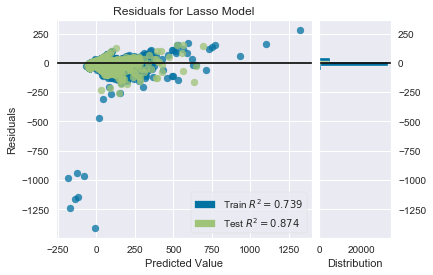

In [117]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
X_poly_s = scaler.transform(X_poly)

X_test_poly = poly_reg.transform(X_test)
X_test_poly_s = scaler.transform(X_test_poly)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)
print(f'Training score: {lasso.score(X_poly_s,y_train)}')
print(f'Testing score: {lasso.score(X_test_poly_s,y_test)}')
visualizer = ResidualsPlot(lasso)
visualizer.fit(X_poly_s, y_train)
visualizer.score(X_test_poly_s, y_test)
visualizer.show();

As shown above, the test residuals 'match' the train residuals; the scores are comparable. This tells us the model is robust. The scores are relatively low (XX%) but it is better than the XX% we had in our baseline model.

The residuals graph shows there is a bias in the data, and there is some heteroscedasticity. We think by doing a better job at selecting our features this could be optimised.

The number of features, as well as the features themselves, used in this model were selected on an intuitive basis. We did this in order to improve the interpretability of the model, as opposed to select more variables or more complex interactions in order to get a more accurate model.

## Weight of the variables/interactions

In this section we are going to descale and defactorise our coefficients so we will be able to see in which extent the affect the MVD.

In [118]:
coefname = poly_reg.get_feature_names(X_train.columns)
coefvalue = lasso.coef_
df = pd.DataFrame(list(zip(coefname,coefvalue)))
df.columns = ['Coefficient','ScaledValue']
df['PolyValue'] = scaler.inverse_transform(df['ScaledValue'])
df['Value'] = df['PolyValue']**(1./3)
df = df[df['ScaledValue']!=0]
df = df.sort_values(by='Value', ascending=False)
df

,Coefficient,ScaledValue,PolyValue,Value
110,DEPARTURE_TIME^3,89.282803,2.243061e+11,6075.942951
100,SCHEDULED_DEPARTURE^3,40.360245,9.863016e+10,4620.297128
106,SCHEDULED_DEPARTURE DEPARTURE_TIME DISTANCE,9.891701,1.196162e+10,2286.984984
102,SCHEDULED_DEPARTURE^2 AIR_TIME,35.872670,5.467770e+09,1761.719438
112,DEPARTURE_TIME^2 DISTANCE,3.247759,4.614401e+09,1664.837186
...,...,...,...,...
103,SCHEDULED_DEPARTURE^2 DISTANCE,-17.622592,-1.851380e+10,NaN
104,SCHEDULED_DEPARTURE DEPARTURE_TIME^2,-32.078755,-7.535310e+10,NaN
105,SCHEDULED_DEPARTURE DEPARTURE_TIME AIR_TIME,-54.206874,-8.002350e+09,NaN
107,SCHEDULED_DEPARTURE AIR_TIME^2,-9.121037,-1.480495e+08,NaN


In [119]:
lasso.intercept_

6.497404754489793

In [123]:
lasso.coef_[111]

18.98092800265966